In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [79]:
train_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
is_null_values = train_data.isnull().sum()
is_null_values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

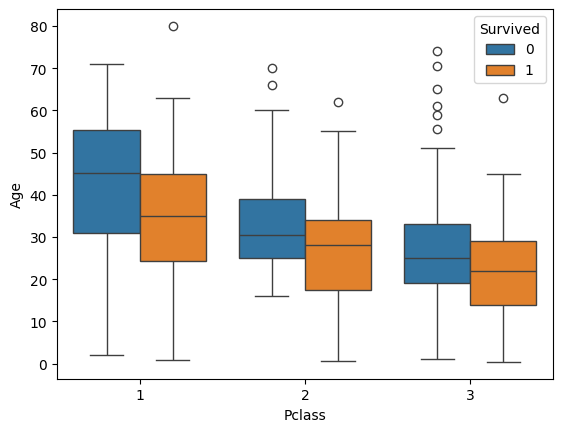

In [6]:
sns.boxplot(data = train_data, x = "Pclass", y = "Age", hue = "Survived")
plt.show()

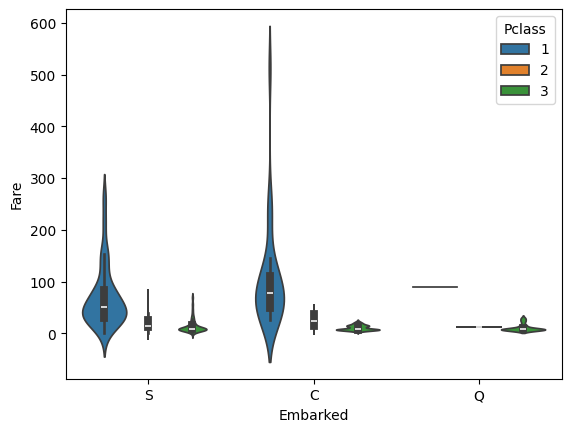

In [7]:
sns.violinplot(data = train_data, x = "Embarked", y = "Fare", hue = "Pclass", palette = "tab10")
plt.show()

In [64]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [80]:
train_df = train_data.drop(columns = ["PassengerId", "Survived", "Cabin"])
test_df = test_data.drop(columns = ["PassengerId", "Cabin"])

In [81]:
train_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [82]:
train_null_values = train_df.isnull().sum()
train_null_values

Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
dtype: int64

In [83]:
def preprocessing(data: pd.DataFrame):
    df = data.copy()

    df["Title"] = df["Name"].str.split(", ", expand = True)[1].str.split(". ", expand = True)[0]
    df["Family_Size"] = df["SibSp"] + df["Parch"] + 1

    df["Title"] = df["Title"].map({"Mme": "Mrs", "Mlle": "Miss", "Ms": "Miss", "Sir": "Mr"}, na_action = "ignore").fillna(df["Title"])
    df["Title"] = df["Title"].apply(lambda x: "None" if x in ["Capt", "Col", "Don", "Jonkheer", "Major", "th"] else x)

    return df.drop(columns = ["Name", "Ticket"])

In [84]:
train_df = preprocessing(train_df)

In [85]:
simple_imputer = SimpleImputer(strategy = "most_frequent")
train_df["Embarked"] = simple_imputer.fit_transform(train_df[["Embarked"]]).reshape(-1)

In [86]:
train_null_values = train_df.isnull().sum()
train_null_values

Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
Title            0
Family_Size      0
dtype: int64

In [87]:
original_age_values = train_df["Age"].dropna()
original_age_values

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
885    39.0
886    27.0
887    19.0
889    26.0
890    32.0
Name: Age, Length: 714, dtype: float64

In [88]:
age_fillna_df = train_df.dropna(subset = ["Age"], axis = 0)
age_fillna_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size
0,3,male,22.0,1,0,7.2500,S,Mr,2
1,1,female,38.0,1,0,71.2833,C,Mrs,2
2,3,female,26.0,0,0,7.9250,S,Miss,1
3,1,female,35.0,1,0,53.1000,S,Mrs,2
4,3,male,35.0,0,0,8.0500,S,Mr,1
...,...,...,...,...,...,...,...,...,...
885,3,female,39.0,0,5,29.1250,Q,Mrs,6
886,2,male,27.0,0,0,13.0000,S,Rev,1
887,1,female,19.0,0,0,30.0000,S,Miss,1
889,1,male,26.0,0,0,30.0000,C,Mr,1


In [89]:
missing_indices = np.random.choice(age_fillna_df.index, size = 142, replace = False)
age_fillna_df.loc[missing_indices, "Age"] = np.nan
age_fillna_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size
0,3,male,22.0,1,0,7.2500,S,Mr,2
1,1,female,38.0,1,0,71.2833,C,Mrs,2
2,3,female,NaN,0,0,7.9250,S,Miss,1
3,1,female,35.0,1,0,53.1000,S,Mrs,2
4,3,male,35.0,0,0,8.0500,S,Mr,1
...,...,...,...,...,...,...,...,...,...
885,3,female,39.0,0,5,29.1250,Q,Mrs,6
886,2,male,27.0,0,0,13.0000,S,Rev,1
887,1,female,19.0,0,0,30.0000,S,Miss,1
889,1,male,26.0,0,0,30.0000,C,Mr,1


In [90]:
age_fillna_df_transformed = pd.get_dummies(age_fillna_df, columns = ["Pclass", "Sex", "Embarked", "Title"], drop_first = True)

In [91]:
scaler = RobustScaler()
scaler_data = scaler.fit_transform(age_fillna_df_transformed)
age_fillna_df_scaled = pd.DataFrame(scaler_data, columns = scaler.feature_names_in_)
age_fillna_df_scaled

,Age,SibSp,Parch,Fare,Family_Size,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Lady,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_None,Title_Rev
0,-0.386207,1.0,0.0,-0.335309,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.496552,1.0,0.0,2.193153,1.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
2,NaN,0.0,0.0,-0.308655,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
3,0.331034,1.0,0.0,1.475155,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
4,0.331034,0.0,0.0,-0.303720,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,0.551724,0.0,5.0,0.528462,5.0,0.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
710,-0.110345,0.0,0.0,-0.108261,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0
711,-0.551724,0.0,0.0,0.563013,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
712,-0.165517,0.0,0.0,0.563013,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
knn_imputer = KNNImputer()
age_prediction = knn_imputer.fit_transform(age_fillna_df_scaled)
age_prediction_df = pd.DataFrame(age_prediction, columns = knn_imputer.feature_names_in_)
age_prediction_df

,Age,SibSp,Parch,Fare,Family_Size,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Lady,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_None,Title_Rev
0,-0.386207,1.0,0.0,-0.335309,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.496552,1.0,0.0,2.193153,1.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
2,-0.253793,0.0,0.0,-0.308655,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
3,0.331034,1.0,0.0,1.475155,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
4,0.331034,0.0,0.0,-0.303720,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,0.551724,0.0,5.0,0.528462,5.0,0.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
710,-0.110345,0.0,0.0,-0.108261,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0
711,-0.551724,0.0,0.0,0.563013,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
712,-0.165517,0.0,0.0,0.563013,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
age_prediction_df_unscaled = pd.DataFrame(scaler.inverse_transform(age_prediction_df), columns = scaler.feature_names_in_)
age_prediction_df_unscaled

,Age,SibSp,Parch,Fare,Family_Size,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Lady,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_None,Title_Rev
0,22.0,1.0,0.0,7.2500,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38.0,1.0,0.0,71.2833,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,24.4,0.0,0.0,7.9250,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,35.0,1.0,0.0,53.1000,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,35.0,0.0,0.0,8.0500,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,39.0,0.0,5.0,29.1250,6.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
710,27.0,0.0,0.0,13.0000,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
711,19.0,0.0,0.0,30.0000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
712,26.0,0.0,0.0,30.0000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [94]:
root_mean_squared_error(original_age_values, age_prediction_df_unscaled["Age"])

5.420124854629819

In [95]:
def imputer_optimization():
    scores = []

    for k in range(20, 51):
        for weight in ["uniform", "distance"]:
            imputer = KNNImputer(n_neighbors = k, weights = weight)
            age_prediction = imputer.fit_transform(age_fillna_df_scaled)
            age_prediction_df = pd.DataFrame(age_prediction, columns = knn_imputer.feature_names_in_)
            age_prediction_df_unscaled = pd.DataFrame(scaler.inverse_transform(age_prediction_df), columns = scaler.feature_names_in_)
            scores.append([[k, weight, root_mean_squared_error(original_age_values, age_prediction_df_unscaled["Age"])]])

    #return np.array(scores)
    return pd.DataFrame(np.array(scores).reshape(-1, 3), columns = ["K", "Weights", "RMSE"])

In [96]:
imputer_optimization().sort_values(by = "RMSE")

,K,Weights,RMSE
2,21,uniform,4.816373714282934
4,22,uniform,4.81687116766841
8,24,uniform,4.830530348442717
10,25,uniform,4.830869869671826
0,20,uniform,4.831429021962105
...,...,...,...
9,24,distance,6.080575480677259
5,22,distance,6.097313852444244
3,21,distance,6.098978708205879
7,23,distance,6.100439238844764


In [97]:
age_fill_groupby = age_fillna_df.groupby(by = ["Sex", "Pclass"])["Age"].transform(lambda x: x.fillna(x.median()))
age_fill_groupby

0      22.0
1      38.0
2      21.0
3      35.0
4      35.0
       ... 
885    39.0
886    27.0
887    19.0
889    26.0
890    32.0
Name: Age, Length: 714, dtype: float64

In [98]:
root_mean_squared_error(original_age_values, age_fill_groupby)

5.220607853358018

In [100]:
train_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size
0,3,male,22.0,1,0,7.2500,S,Mr,2
1,1,female,38.0,1,0,71.2833,C,Mrs,2
2,3,female,26.0,0,0,7.9250,S,Miss,1
3,1,female,35.0,1,0,53.1000,S,Mrs,2
4,3,male,35.0,0,0,8.0500,S,Mr,1
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S,Rev,1
887,1,female,19.0,0,0,30.0000,S,Miss,1
888,3,female,NaN,1,2,23.4500,S,Miss,4
889,1,male,26.0,0,0,30.0000,C,Mr,1


In [109]:
knn_imputer = KNNImputer(n_neighbors = 21, weights = "uniform")
scaler = RobustScaler()
train_df_encoded = pd.get_dummies(train_df, columns = ["Pclass", "Sex", "Embarked", "Title"], drop_first = True)
train_df_encoded_scaled = pd.DataFrame(scaler.fit_transform(train_df_encoded), columns = scaler.feature_names_in_)
train_df_encoded_age_predicted = pd.DataFrame(knn_imputer.fit_transform(train_df_encoded_scaled), columns = knn_imputer.feature_names_in_)
train_df_encoded_age_predicted_unscaled = pd.DataFrame(scaler.inverse_transform(train_df_encoded_age_predicted), columns = scaler.feature_names_in_)
train_df["Age"] = train_df_encoded_age_predicted_unscaled["Age"].round(2)

In [110]:
train_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size
0,3,male,22.0,1,0,7.2500,S,Mr,2
1,1,female,38.0,1,0,71.2833,C,Mrs,2
2,3,female,26.0,0,0,7.9250,S,Miss,1
3,1,female,35.0,1,0,53.1000,S,Mrs,2
4,3,male,35.0,0,0,8.0500,S,Mr,1
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S,Rev,1
887,1,female,19.0,0,0,30.0000,S,Miss,1
888,3,female,12.6,1,2,23.4500,S,Miss,4
889,1,male,26.0,0,0,30.0000,C,Mr,1


In [111]:
train_df.isnull().sum()

Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
Family_Size    0
dtype: int64

In [112]:
train_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size
0,3,male,22.0,1,0,7.2500,S,Mr,2
1,1,female,38.0,1,0,71.2833,C,Mrs,2
2,3,female,26.0,0,0,7.9250,S,Miss,1
3,1,female,35.0,1,0,53.1000,S,Mrs,2
4,3,male,35.0,0,0,8.0500,S,Mr,1
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S,Rev,1
887,1,female,19.0,0,0,30.0000,S,Miss,1
888,3,female,12.6,1,2,23.4500,S,Miss,4
889,1,male,26.0,0,0,30.0000,C,Mr,1


In [113]:
survival_by_title = pd.concat([train_df, train_data["Survived"]], axis = 1).rename(columns = {0: "Survived"}).groupby(by = "Survived")["Title"].value_counts()
survival_by_title

Survived  Title 
0         Mr        436
          Miss       55
          Mrs        26
          Master     17
          Rev         6
          None        5
          Dr          4
1         Miss      130
          Mrs       100
          Mr         82
          Master     23
          Dr          3
          None        3
          Lady        1
Name: count, dtype: int64

In [114]:
train_df.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size
0,3,male,22.0,1,0,7.2500,S,Mr,2
1,1,female,38.0,1,0,71.2833,C,Mrs,2


In [115]:
X_train = train_df.copy()
y = train_data["Survived"]

In [116]:
X_encoded = pd.get_dummies(X_train, columns = ["Pclass", "Sex", "Embarked", "Title"], drop_first = True)
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_encoded), columns = scaler.feature_names_in_)

In [117]:
X_scaled

,Age,SibSp,Parch,Fare,Family_Size,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Lady,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_None,Title_Rev
0,-0.447141,1.0,0.0,-0.312011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.574896,1.0,0.0,2.461242,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
2,-0.191632,0.0,0.0,-0.282777,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
3,0.383264,1.0,0.0,1.673732,1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0
4,0.383264,0.0,0.0,-0.277363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.127755,0.0,0.0,-0.062981,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1.0
887,-0.638774,0.0,0.0,0.673281,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
888,-1.047589,1.0,2.0,0.389604,3.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0
889,-0.191632,0.0,0.0,0.673281,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
rf_model = RandomForestClassifier()
cross_val_score(rf_model, X_scaled, y, cv = 50).mean()

0.8139869281045751

In [119]:
rf_model.fit(X_scaled, y)
fts = pd.Series(rf_model.feature_importances_, index = rf_model.feature_names_in_).sort_values(ascending = False)

In [120]:
fts

Age             0.239465
Fare            0.223541
Sex_male        0.132073
Title_Mr        0.115992
Pclass_3        0.056036
Family_Size     0.053172
Title_Miss      0.037247
SibSp           0.032999
Title_Mrs       0.030600
Parch           0.019250
Embarked_S      0.018472
Pclass_2        0.014904
Embarked_Q      0.008939
Title_Master    0.008930
Title_Rev       0.005369
Title_None      0.002870
Title_Lady      0.000141
dtype: float64

In [121]:
ada_model = AdaBoostClassifier(algorithm = "SAMME")
cross_val_score(ada_model, X_scaled, y, cv = 50).mean()

0.8194771241830066

In [122]:
test_df_preprocessed = preprocessing(test_df)
test_df_preprocessed

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size
0,3,male,34.5,0,0,7.8292,Q,Mr,1
1,3,female,47.0,1,0,7.0000,S,Mrs,2
2,2,male,62.0,0,0,9.6875,Q,Mr,1
3,3,male,27.0,0,0,8.6625,S,Mr,1
4,3,female,22.0,1,1,12.2875,S,Mrs,3
...,...,...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S,Mr,1
414,1,female,39.0,0,0,108.9000,C,Dona,1
415,3,male,38.5,0,0,7.2500,S,Mr,1
416,3,male,NaN,0,0,8.0500,S,Mr,1


In [123]:
X_pred = test_df_preprocessed.copy()

In [124]:
X_pred.isnull().sum()

Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
Title           0
Family_Size     0
dtype: int64

In [125]:
test_df_preprocessed["Fare"] = test_df_preprocessed.groupby(by = ["Pclass", "Embarked"])["Fare"].transform(lambda x: x.fillna(x.median()))

In [126]:
test_df_preprocessed.isnull().sum()

Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            0
Embarked        0
Title           0
Family_Size     0
dtype: int64

In [55]:
test_df_preprocessed.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size
0,3,male,34.5,0,0,7.8292,Q,Mr,1
1,3,female,47.0,1,0,7.0000,S,Mrs,2


In [129]:
test_df_preprocessed_encoded = pd.get_dummies(test_df_preprocessed, columns = ["Pclass", "Sex", "Embarked", "Title"], drop_first = True)
test_df_preprocessed_encoded

,Age,SibSp,Parch,Fare,Family_Size,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_None,Title_Rev
0,34.5,0,0,7.8292,1,False,True,True,True,False,False,False,False,True,False,False,False
1,47.0,1,0,7.0000,2,False,True,False,False,True,False,False,False,False,True,False,False
2,62.0,0,0,9.6875,1,True,False,True,True,False,False,False,False,True,False,False,False
3,27.0,0,0,8.6625,1,False,True,True,False,True,False,False,False,True,False,False,False
4,22.0,1,1,12.2875,3,False,True,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,0,0,8.0500,1,False,True,True,False,True,False,False,False,True,False,False,False
414,39.0,0,0,108.9000,1,False,False,False,False,False,False,False,False,False,False,False,False
415,38.5,0,0,7.2500,1,False,True,True,False,True,False,False,False,True,False,False,False
416,NaN,0,0,8.0500,1,False,True,True,False,True,False,False,False,True,False,False,False
